## Library

In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.optim.lr_scheduler import LambdaLR

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy

## Developed code

In [2]:
from SymbolicRNN import SymbolicRNN
from stringAgraph import stringAgraph
from evaluateAgraph import evaluateAgraph
from localOptimizer import localOptimizer
from Agraph import Agraph, binary_node
from defineAgraph import defineAgraph

In [3]:
if torch.cuda.is_available():
    print("Good to go!")
    device = "cuda"
else:
    device = 'cpu'

Good to go!


## Select operators 

In [4]:
selected_operator = ['+','-','*','/']

In [5]:
idx_to_op = ['<NULL>','c','x']
idx_to_op += selected_operator
op_to_idx = {w: i for i, w in enumerate(idx_to_op)}
D = len(idx_to_op)
print("The size of dictionary is:{}".format(D))
print("idx_to_op:",idx_to_op)
print("op_to_idx:",op_to_idx)

The size of dictionary is:7
idx_to_op: ['<NULL>', 'c', 'x', '+', '-', '*', '/']
op_to_idx: {'<NULL>': 0, 'c': 1, 'x': 2, '+': 3, '-': 4, '*': 5, '/': 6}


## Training algorithm

In [6]:
def training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method):
    
    model = SymbolicRNN(idx_to_op,op_to_idx,
                     X,y,
                     method,maxiter,threshold,
                     D,E,H)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_model = None
    best_reward = -np.inf
    reward_array = []
    loss_array = []
    cost_array = []
    s_lr = lr
    for j in range(epoch):
        
        optimizer.zero_grad()
        agraph,loss,reward,cost = model(deterministic=False)
        loss.backward()
        optimizer.step()
        
        if reward>best_reward:
            best_model = model
            best_reward = reward
            best_agraph = agraph
            
        reward_array.append(best_reward)
        loss_array.append(loss.item())
        cost_array.append(cost.item())
        if j%100==0 or j==epoch-1:
            print('epoch {}'.format(j))
            print('Reward is:',reward)
            print("Possbility:")
            print(agraph.p_tau)
            print("Selected operator:")
            print(agraph.preorder)
            exp = stringAgraph(agraph.root,idx_to_op)
            print("Obtained equation is:",sympy.expand(exp))
            print()
        
        if torch.all(agraph.p_tau>0.92).item() and reward>0.99:
            break
            
            
    print('Terminate at epoch {}'.format(j))
    print('Reward is:',reward)
    exp = stringAgraph(agraph.root,idx_to_op)
    print("Obtained equation is:",sympy.expand(exp))
    print()
    return best_agraph,best_model,model,reward_array,loss_array,cost_array

In [7]:
def sampling_equation(model,idx_to_op,n):
    for i in range(n):
        print("###### Start {}-test ######".format(i+1))
        agraph,loss,reward,cost = model(deterministic=False)
        p_tau = agraph.p_tau
        operators = agraph.preorder
        exp = stringAgraph(agraph.root,idx_to_op)
        print('Obtained equation is: ',sympy.expand(exp))
        print('Reward is:,',reward)
        if i==0:
            for j in range(len(p_tau)):
                p,op = p_tau[j],operators[j]
                p*=100
                p = np.round(p.item(),2)
                print('Node {}: {} is sampled with {}%'.format(j+1,idx_to_op[int(op)],p))
        
        print("###### End {}-test ######".format(i+1))
        print()
    return agraph

## Test-1

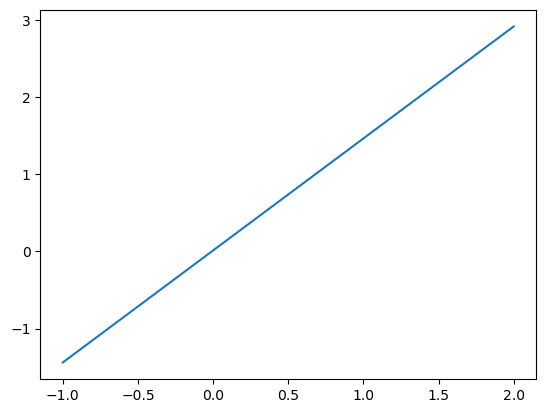

In [8]:
n = 50
X = np.linspace(-1,2,n)
y = 1.452*X + 0.012
plt.plot(X,y)

In [16]:
D,E,H = len(idx_to_op),30,30
maxiter = 11
threshold = 0.85
epoch = 2000
method = 'rmm'
lr = 1e-2
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.5
Possbility:
tensor([0.2508, 0.1245, 0.1577, 0.3120, 0.3401, 0.5457, 0.4572, 0.8204, 0.4992,
        0.4811, 0.7047], grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 4., 3., 6., 5., 2., 2., 2., 1., 2., 1.])
Obtained equation is: 0.73800000301829961

epoch 100
Reward is: 0.5
Possbility:
tensor([0.9796, 0.4587, 0.8647, 0.9999, 0.9578, 0.9751, 0.0695, 1.0000, 1.0000,
        0.5771, 0.9984], grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 1., 4., 1., 6., 6., 5., 1., 2., 2., 1.])
Obtained equation is: 0.73799998951845212

epoch 200
Reward is: 0.4999999999997824
Possbility:
tensor([0.9877, 0.7408, 0.9999, 0.9999, 0.9925, 0.9383, 0.9681, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 6., 4., 1., 5., 1., 6., 1., 2., 1., 1.])
Obtained equation is: 0.7380015664986289 - 1.192190163519996e-13/x

epoch 300
Reward is: 0.9975410527096417
Possbility:
tensor([0.9972, 0.9167, 0.9974, 0.9841, 0.0654, 0.9886, 0.944

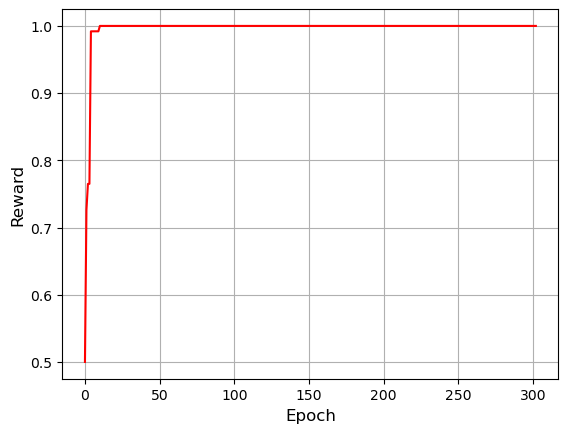

In [17]:
plt.plot(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

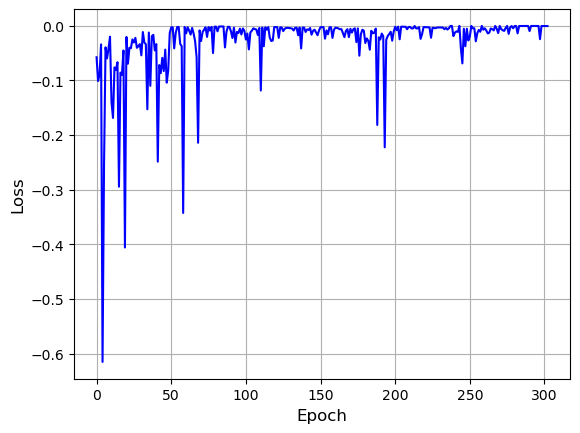

In [18]:
plt.plot(loss_array,color='blue')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.grid()

In [19]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('The best equation is: ',sympy.expand(exp))
print('Target expression is: 1.452*X + 0.012')

The best equation is:  1.452000001539855*x + 0.011999999140358422
Target expression is: 1.452*X + 0.012


In [20]:
# Sampling from DSR model (20 times)
n = 20
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  465.94520155692484 - 149049.0422126822/(x + 319.89524575140933)
Reward is:, 0.9975410527096417
Node 1: - is sampled with 99.7%
Node 2: c is sampled with 92.29%
Node 3: + is sampled with 99.74%
Node 4: c is sampled with 98.4%
Node 5: * is sampled with 99.67%
Node 6: c is sampled with 98.88%
Node 7: / is sampled with 92.79%
Node 8: c is sampled with 99.99%
Node 9: + is sampled with 91.95%
Node 10: c is sampled with 100.0%
Node 11: x is sampled with 100.0%
###### End 1-test ######

###### Start 2-test ######
Obtained equation is:  465.94520155692484 - 149049.0422126822/(x + 319.89524575140933)
Reward is:, 0.9975410527096417
###### End 2-test ######

###### Start 3-test ######
Obtained equation is:  465.94520155692484 - 149049.0422126822/(x + 319.89524575140933)
Reward is:, 0.9975410527096417
###### End 3-test ######

###### Start 4-test ######
Obtained equation is:  465.94520155692484 - 149049.0422126822/(x + 319.89524575140933)
Reward is:

In [21]:
# Evaluate best model and DSR model
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

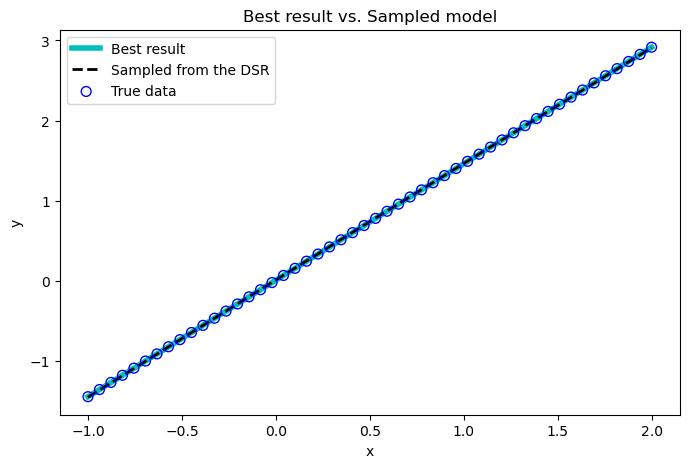

In [22]:
plt.figure(figsize = (8,5))
plt.plot(X,y_hat_best,color='c',linewidth = 4,label='Best result')
plt.plot(X,y_hat_model,'k--',linewidth=2,label='Sampled from the DSR')
plt.scatter(X,y,facecolor='none',edgecolor='b',zorder=3,s=50,label='True data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best result vs. Sampled model')
plt.legend()

## Test-2

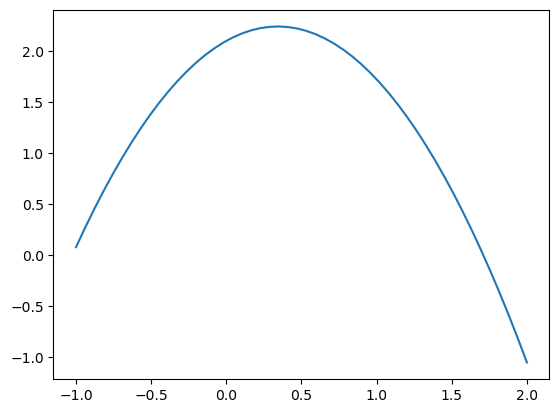

In [34]:
n = 50
X = np.linspace(-1,2,n)
y = -1.2*X**2 + 0.823*X + 2.1
plt.plot(X,y)

In [54]:
D,E,H = len(idx_to_op),30,30
maxiter = 25
threshold = 0.9
epoch = 2000
method = 'rmm'
lr = 5e-3
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.3789442406125225
Possbility:
tensor([0.2328, 0.2848, 0.1003], grad_fn=<SliceBackward0>)
Selected operator:
tensor([3., 1., 2.])
Obtained equation is: x + 0.7747652911142691

epoch 100
Reward is: 0.5183544606175455
Possbility:
tensor([0.3049, 0.9118, 0.3637, 0.2256, 0.6261, 0.7709, 0.9855, 0.0843, 0.1712,
        0.7900, 0.3678, 0.9803, 0.2987, 0.4966, 0.9879, 0.8570, 0.9100, 0.9974,
        0.7490, 0.2024, 0.9919, 0.3937, 0.9988, 0.9999, 0.9961],
       grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 4., 3., 5., 4., 4., 5., 4., 3., 2., 6., 4., 5., 2., 1., 2., 2., 1.,
        1., 1., 2., 1., 1., 1., 1.])
Obtained equation is: 1.4632653091220173 - 0.37699999342081346*x

epoch 200
Reward is: 0.649339185309161
Possbility:
tensor([0.8459, 0.9815, 0.7143, 0.7315, 0.0083, 0.9963, 0.9999, 0.9982, 0.8170,
        0.8052, 0.9425, 0.9916, 0.9321, 1.0000, 0.9874, 0.7841, 0.9967, 0.9330,
        0.9988, 0.9941, 0.9936, 0.9994, 0.9982, 0.9999, 0.9967],
       grad_fn=<S

KeyboardInterrupt: 

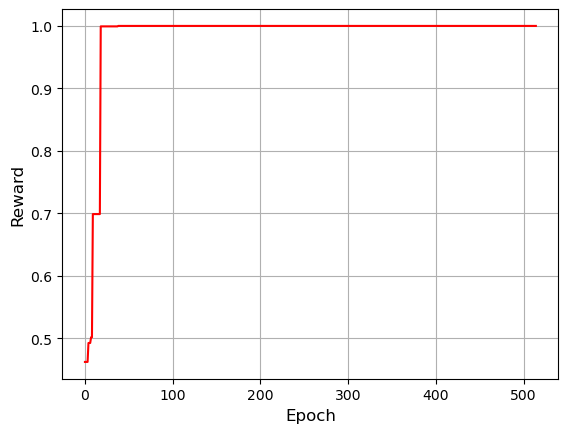

In [44]:
plt.plot(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

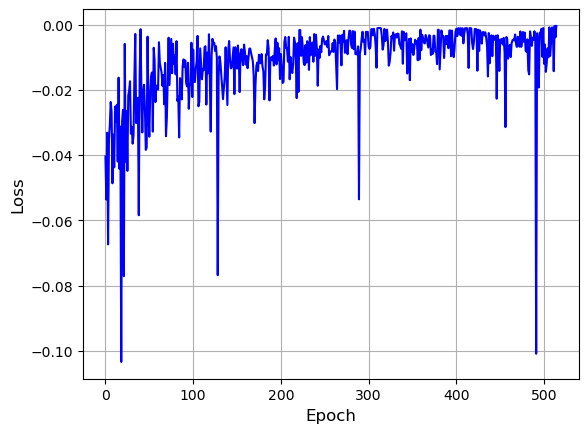

In [45]:
plt.plot(loss_array,color='blue')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.grid()

In [46]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('The best equation is: ',sympy.expand(exp))
print('Target expression is: - 1.2*X**2 + 0.823*X + 2.1')

The best equation is:  -1.2000000040788681*x**2 + 0.82300000283145872*x + 2.1000000007176778
Target expression is: - 1.2*X**2 + 0.823*X + 2.1


In [50]:
# Sampling from DSR model (20 times)
n = 20
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  -1.1999999729292657*x**2 + 0.82299995469119564*x + 2.0999999649718996
Reward is:, 0.9999999569720103
Node 1: - is sampled with 99.31%
Node 2: - is sampled with 99.97%
Node 3: + is sampled with 93.68%
Node 4: + is sampled with 99.56%
Node 5: + is sampled with 99.7%
Node 6: x is sampled with 99.69%
Node 7: + is sampled with 99.56%
Node 8: x is sampled with 99.95%
Node 9: * is sampled with 100.0%
Node 10: * is sampled with 100.0%
Node 11: * is sampled with 100.0%
Node 12: / is sampled with 99.92%
Node 13: / is sampled with 99.45%
Node 14: - is sampled with 95.21%
Node 15: c is sampled with 99.98%
Node 16: x is sampled with 22.77%
Node 17: c is sampled with 99.98%
Node 18: c is sampled with 99.99%
Node 19: c is sampled with 100.0%
Node 20: c is sampled with 99.98%
Node 21: x is sampled with 100.0%
Node 22: x is sampled with 99.96%
Node 23: x is sampled with 99.63%
Node 24: c is sampled with 100.0%
Node 25: c is sampled with 99.99%
###### En

In [51]:
# Evaluate best model and DSR model
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

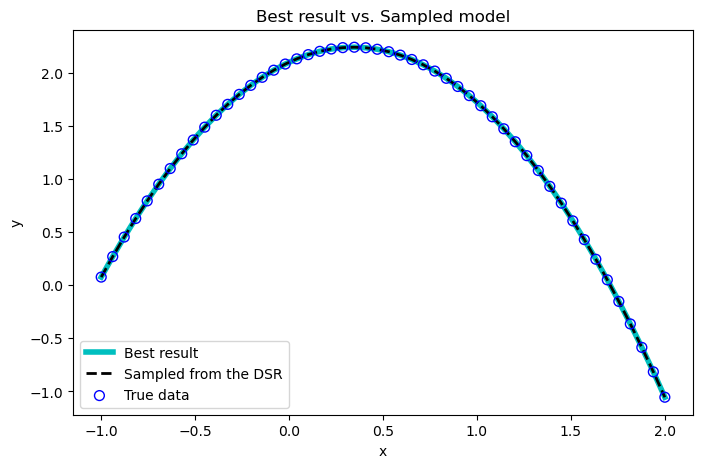

In [52]:
plt.figure(figsize = (8,5))
plt.plot(X,y_hat_best,color='c',linewidth = 4,label='Best result')
plt.plot(X,y_hat_model,'k--',linewidth=2,label='Sampled from the DSR')
plt.scatter(X,y,facecolor='none',edgecolor='b',zorder=3,s=50,label='True data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best result vs. Sampled model')
plt.legend()

## Test-3

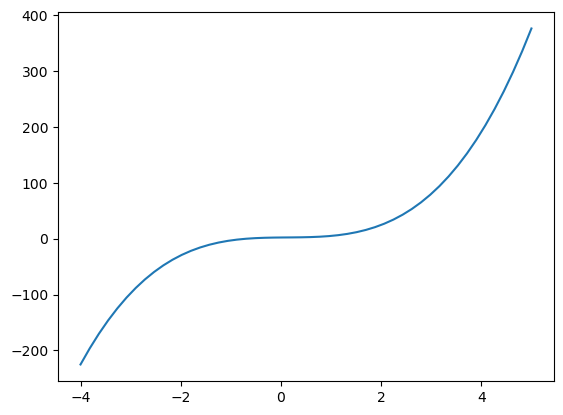

In [24]:
n = 50
X = np.linspace(-4,5,n)
y = 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1
plt.plot(X,y)

In [25]:
D,E,H = len(idx_to_op),40,40
maxiter = 33
threshold = 0.8
epoch = 1000
method = 'rmm'
lr = 5e-3
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.7146953520753477
Possbility:
tensor([0.3242, 0.1249, 0.2100, 0.2571, 0.0610, 0.1701, 0.1865, 0.4193, 0.2928,
        0.2279, 0.1939, 0.1220, 0.3026, 0.2014, 0.1671, 0.0801, 0.1832, 0.1308,
        0.1290], grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 5., 1., 5., 3., 2., 4., 1., 4., 2., 2., 1., 4., 4., 1., 5., 2., 2.,
        2.])
Obtained equation is: x**2 + 41.46834572714741*x - 0.10635124973277847

epoch 100
Reward is: 0.5024174331564171
Possbility:
tensor([0.7760, 0.9844, 0.8635, 0.8965, 0.9908, 0.9911, 0.7745, 0.9038, 0.9609,
        0.8123, 0.9629, 0.9613, 0.9968, 0.9489, 0.9638, 0.9940, 0.9829, 0.9980,
        1.0000, 0.9999, 0.9313, 0.9949, 0.9687, 0.9686, 0.9681, 0.9857, 0.9353,
        0.9571, 0.9990, 0.9969, 0.9880, 0.7167, 0.9978],
       grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 1., 6., 4., 5., 5., 6., 4., 4., 5., 5., 6., 6., 3., 5., 4., 6., 1.,
        2., 1., 1., 2., 2., 1., 2., 1., 1., 2., 1., 1., 1., 1., 2.])
Obtained equa

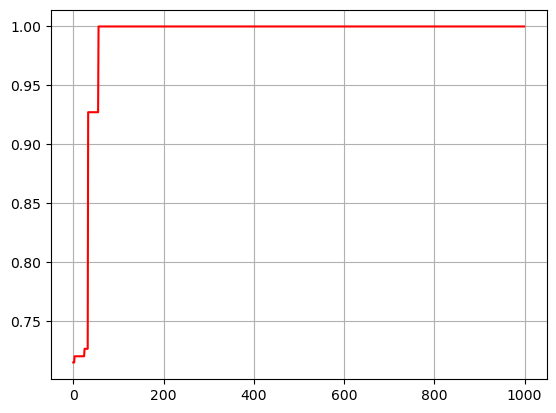

In [26]:
plt.plot(np.arange(0,len(reward_array)),reward_array,color='red')
plt.grid()

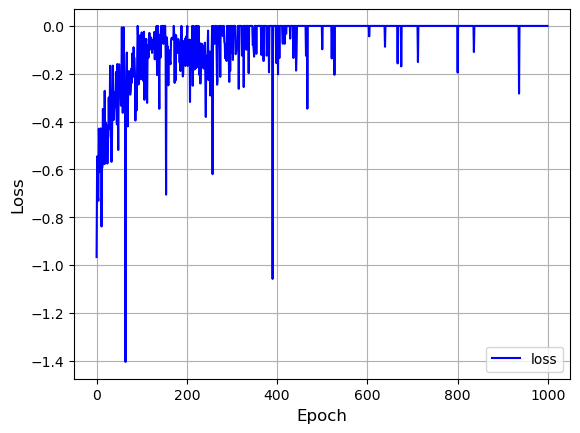

In [27]:
plt.plot(loss_array,label='loss',color='blue')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.grid()
plt.legend()

In [28]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('The best equation is: ',sympy.expand(exp))
print('Target expression is: 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1')

The best equation is:  3.1999999596096857*x**3 - 1.1999999885499139*x**2 + 0.8230005521272564*x + 2.09999970773445
Target expression is: 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1


In [29]:
# Sampling from DSR model (20 times)
n = 20
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  3.2000165748521982*x**3 - 1.2000107765230639*x**2 + 0.82278764027566063*x + 2.0999251870898562
Reward is:, 0.9999978172332699
Node 1: * is sampled with 17.14%
Node 2: + is sampled with 99.93%
Node 3: * is sampled with 99.96%
Node 4: - is sampled with 99.96%
Node 5: * is sampled with 100.0%
Node 6: * is sampled with 100.0%
Node 7: - is sampled with 99.98%
Node 8: - is sampled with 99.99%
Node 9: - is sampled with 98.86%
Node 10: * is sampled with 93.54%
Node 11: * is sampled with 99.87%
Node 12: / is sampled with 99.98%
Node 13: / is sampled with 99.95%
Node 14: + is sampled with 99.46%
Node 15: * is sampled with 99.99%
Node 16: - is sampled with 99.78%
Node 17: c is sampled with 99.93%
Node 18: x is sampled with 100.0%
Node 19: c is sampled with 99.99%
Node 20: c is sampled with 97.24%
Node 21: c is sampled with 100.0%
Node 22: c is sampled with 99.92%
Node 23: x is sampled with 100.0%
Node 24: c is sampled with 100.0%
Node 25: c is sam

In [30]:
# Evaluate best model and DSR model
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

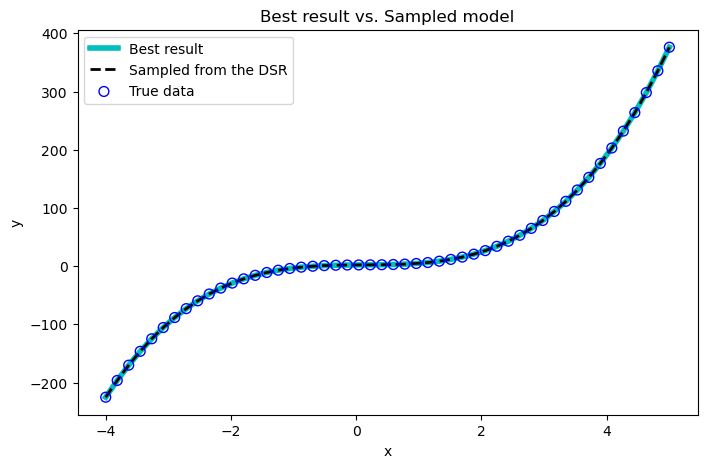

In [31]:
plt.figure(figsize = (8,5))
plt.plot(X,y_hat_best,color='c',linewidth = 4,label='Best result')
plt.plot(X,y_hat_model,'k--',linewidth=2,label='Sampled from the DSR')
plt.scatter(X,y,facecolor='none',edgecolor='b',zorder=3,s=50,label='True data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best result vs. Sampled model')
plt.legend()

## Test-4

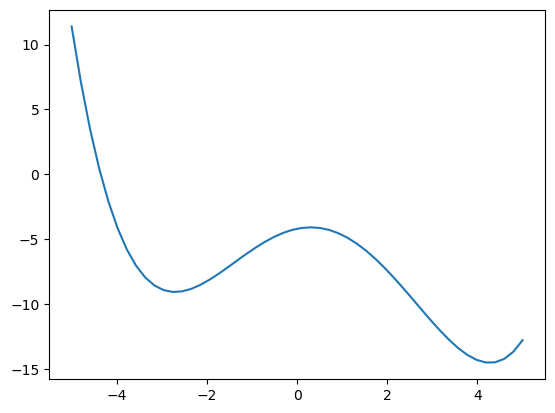

In [54]:
n = 50
X = np.linspace(-5,5,n)
y = 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2
plt.plot(X,y)

In [57]:
D,E,H = len(idx_to_op),40,40
maxiter = 43
threshold = 0.8
epoch = 2000
method = 'rmm'
lr = 5e-3
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.5249293733940136
Possbility:
tensor([0.1977, 0.2359, 0.4915, 0.2663, 0.3492, 0.2243, 0.1528, 0.0724, 0.3101,
        0.2477, 0.3522, 0.2413, 0.2862, 0.1634, 0.1243, 0.3223, 0.2402, 0.4945,
        0.1761, 0.1218, 0.3435, 0.1808, 0.1935, 0.2208, 0.2104, 0.0503, 0.3519,
        0.4343, 0.7814, 0.5474, 0.6318, 0.7542, 0.8605, 0.5556, 0.5344, 0.4011,
        0.7029, 0.7822, 0.6745, 0.3329, 0.4652, 0.5120, 0.3018],
       grad_fn=<SliceBackward0>)
Selected operator:
tensor([5., 5., 6., 1., 5., 6., 3., 5., 2., 3., 5., 3., 4., 5., 2., 6., 5., 3.,
        4., 3., 2., 4., 1., 4., 3., 6., 2., 2., 2., 1., 1., 2., 2., 2., 1., 2.,
        1., 1., 1., 2., 1., 2., 2.])
Obtained equation is: -11.595780374355026*x**3/(1.279109392931317*x**3 - 2.8509786111175718*x**2 + 5.9200876576115812*x - 0.6832240318071332)

epoch 100
Reward is: 0.4999510945388214
Possbility:
tensor([0.5983, 0.5643, 0.9824, 0.4024, 0.9629, 0.9941, 0.9637, 0.8191, 0.7150,
        0.8792, 0.9556, 0.8837, 0.1526, 0

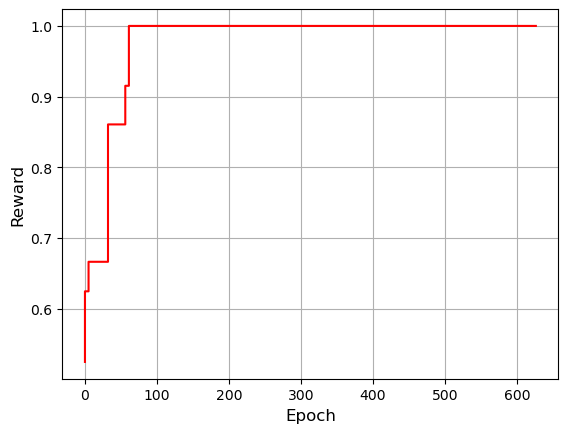

In [58]:
plt.step(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

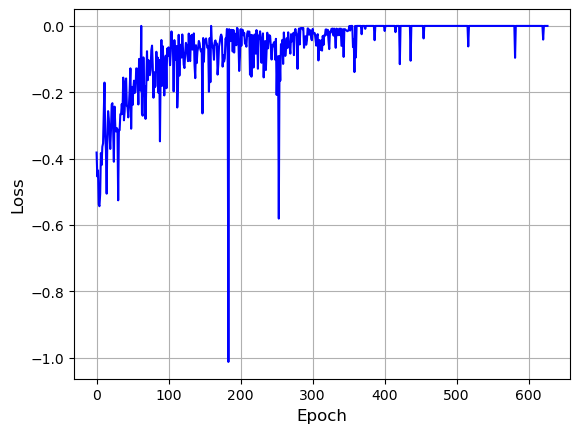

In [59]:
plt.plot(loss_array,color='blue')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.grid()

In [60]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('The best equation is: ',sympy.expand(exp))
print('Target expression is: 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2')

The best equation is:  0.05000000409553133*x**4 - 0.12499999990759995*x**3 - 1.1100001168754662*x**2 + 0.70529996631975112*x - 4.1999994415716095
Target expression is: 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2


In [64]:
# Sampling from DSR model (20 times)
n = 20
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  0.049999999536833592*x**4 - 0.12500002146064325*x**3 - 1.1099999377187407*x**2 + 0.7053004904589399*x - 4.2000009047523812
Reward is:, 0.9999998322460165
Node 1: - is sampled with 91.88%
Node 2: - is sampled with 99.95%
Node 3: * is sampled with 99.9%
Node 4: - is sampled with 99.78%
Node 5: * is sampled with 99.84%
Node 6: + is sampled with 99.96%
Node 7: / is sampled with 99.93%
Node 8: + is sampled with 99.78%
Node 9: / is sampled with 99.88%
Node 10: * is sampled with 98.87%
Node 11: + is sampled with 99.32%
Node 12: + is sampled with 99.65%
Node 13: + is sampled with 99.99%
Node 14: + is sampled with 99.92%
Node 15: - is sampled with 99.18%
Node 16: * is sampled with 99.89%
Node 17: * is sampled with 99.97%
Node 18: - is sampled with 99.95%
Node 19: + is sampled with 99.98%
Node 20: * is sampled with 99.93%
Node 21: c is sampled with 99.89%
Node 22: * is sampled with 99.93%
Node 23: c is sampled with 100.0%
Node 24: x is sampled wi

In [65]:
# Evaluate best model and DSR model
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

Text(0.5, 1.0, 'Best result vs. Sampled model')

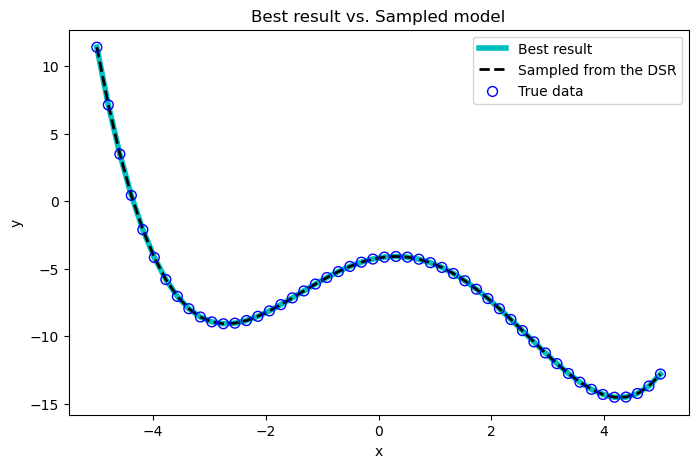

In [66]:
plt.figure(figsize = (8,5))
plt.plot(X,y_hat_best,color='c',linewidth = 4,label='Best result')
plt.plot(X,y_hat_model,'k--',linewidth=2,label='Sampled from the DSR')
plt.scatter(X,y,facecolor='none',edgecolor='b',zorder=3,s=50,label='True data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best result vs. Sampled model')

## Test-5

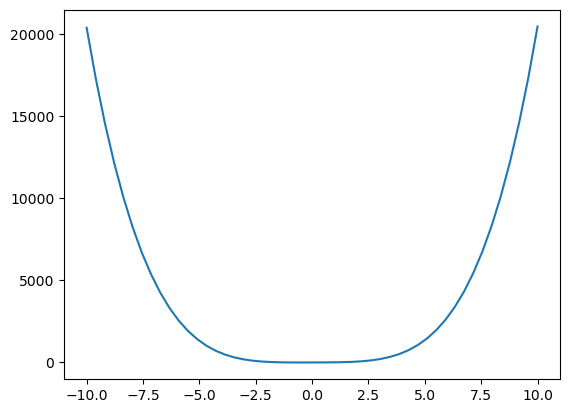

In [40]:
n = 50
X = np.linspace(-10,10,n)
y =  2.01*X**4 + 3.2*X**2 + 4*X 
plt.plot(X,y)

In [41]:
D,E,H = len(idx_to_op),30,30
maxiter = 43
threshold = 0.8
epoch = 1000
method = 'rmm'
lr = 1e-2
best_agraph,best_model,model,reward_array,loss_array,cost_array = training(X,y,lr,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0
Reward is: 0.5002460322094159
Possbility:
tensor([0.2178, 0.1587, 0.1440, 0.3414, 0.2389, 0.1499, 0.1735, 0.1180, 0.1977,
        0.1780, 0.1169, 0.3937, 0.1595, 0.3114, 0.2488, 0.1715, 0.1362, 0.1068,
        0.2275, 0.2265, 0.2024, 0.2677, 0.1642, 0.2678, 0.2058, 0.1274, 0.1308,
        0.4760, 1.0000, 0.5043, 0.6312, 0.5514, 0.4194, 0.6560, 0.6776, 0.8205,
        0.4943, 0.6329, 0.7023, 0.2903, 0.5045, 0.6698, 0.4404],
       grad_fn=<SliceBackward0>)
Selected operator:
tensor([3., 4., 3., 5., 6., 4., 5., 3., 5., 6., 6., 2., 2., 5., 4., 5., 2., 5.,
        2., 4., 5., 2., 3., 2., 6., 3., 6., 1., 2., 1., 1., 1., 2., 1., 2., 2.,
        2., 2., 1., 2., 1., 1., 2.])
Obtained equation is: 0.00089033828104797893*x**3 + 0.00089033828104797893*x**3/(-1.0512061950677374*x**4 + 10.337679988434703*x**3 + 1.638782141118828*x**2 + 1.0512061950677374*x) - 0.00089033828104797893*x**2 + x + 4463.494816884811

epoch 100
Reward is: 0.5101900392404646
Possbility:
tensor([0.8637, 0.7845, 0.99

epoch 999
Reward is: 0.9929335069843576
Possbility:
tensor([0.9999, 0.9986, 0.9999, 0.9981, 0.9999, 1.0000, 1.0000, 0.9999, 1.0000,
        0.9995, 0.9987, 0.9998, 0.9990, 1.0000, 0.9982, 0.9999, 0.9993, 0.9963,
        0.9920, 1.0000, 0.9999, 0.9895, 0.9994, 0.9977, 1.0000, 0.9999, 0.9985,
        1.0000, 0.9993, 0.9997, 1.0000, 0.1663, 0.9994, 1.0000, 0.9998, 1.0000,
        1.0000, 0.9999, 1.0000, 1.0000, 0.9996, 0.9984, 0.9962],
       grad_fn=<SliceBackward0>)
Selected operator:
tensor([4., 2., 4., 4., 5., 5., 5., 5., 1., 4., 1., 4., 5., 5., 3., 6., 4., 4.,
        4., 4., 4., 1., 4., 1., 4., 4., 2., 1., 1., 2., 2., 1., 1., 2., 2., 2.,
        1., 2., 2., 2., 2., 2., 1.])
Obtained equation is: -0.0005259475446587051*x**5 + 2.049425912093094*x**4 + 0.069434601400916729*x**3 + 2*x + 1.0011183821786322

Terminate at epoch 999
Reward is: 0.9929335069843576
Obtained equation is: -0.0005259475446587051*x**5 + 2.049425912093094*x**4 + 0.069434601400916729*x**3 + 2*x + 1.0011183821786322


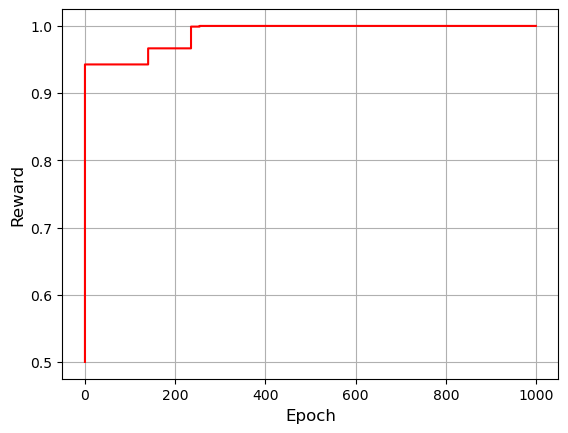

In [48]:
plt.step(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

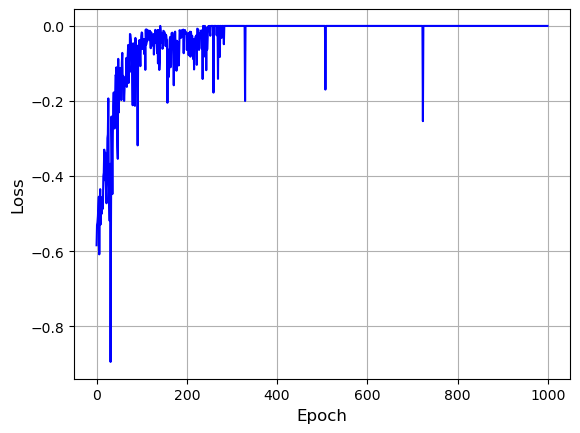

In [49]:
plt.plot(loss_array,color='blue')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.grid()

In [50]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('The best equation is: ',sympy.expand(exp))
print('Target expression is: 2.01*X**4 + 3.2*X**2 + 4*X')

The best equation is:  2.0107771512595476*x**4 - 1.0040615196112157e-6*x**3 + 3.1103811384785523*x**2 + 4.0000289484734209*x + 1.990784818636969
Target expression is: 2.01*X**4 + 3.2*X**2 + 4*X


In [51]:
# Sampling from DSR model (20 times)
n = 20
agraph = sampling_equation(model,idx_to_op,n)

###### Start 1-test ######
Obtained equation is:  -0.00052592753704360539*x**5 + 2.0494260036528382*x**4 + 0.069437466032009865*x**3 + 2*x + 1.0007274862363085
Reward is:, 0.9929334685077897
Node 1: - is sampled with 99.99%
Node 2: x is sampled with 99.86%
Node 3: - is sampled with 99.99%
Node 4: - is sampled with 99.81%
Node 5: * is sampled with 99.99%
Node 6: * is sampled with 100.0%
Node 7: * is sampled with 100.0%
Node 8: * is sampled with 99.99%
Node 9: c is sampled with 100.0%
Node 10: - is sampled with 99.95%
Node 11: c is sampled with 99.87%
Node 12: - is sampled with 99.98%
Node 13: * is sampled with 99.9%
Node 14: * is sampled with 100.0%
Node 15: + is sampled with 99.82%
Node 16: / is sampled with 99.99%
Node 17: - is sampled with 99.93%
Node 18: - is sampled with 99.63%
Node 19: - is sampled with 99.2%
Node 20: - is sampled with 100.0%
Node 21: - is sampled with 99.99%
Node 22: c is sampled with 98.95%
Node 23: - is sampled with 99.94%
Node 24: c is sampled with 99.77%
Node

In [52]:
# Evaluate best model and DSR model
y_hat_best = evaluateAgraph(best_agraph.root,idx_to_op,X,constants=[])
y_hat_model = evaluateAgraph(agraph.root,idx_to_op,X,constants=[])

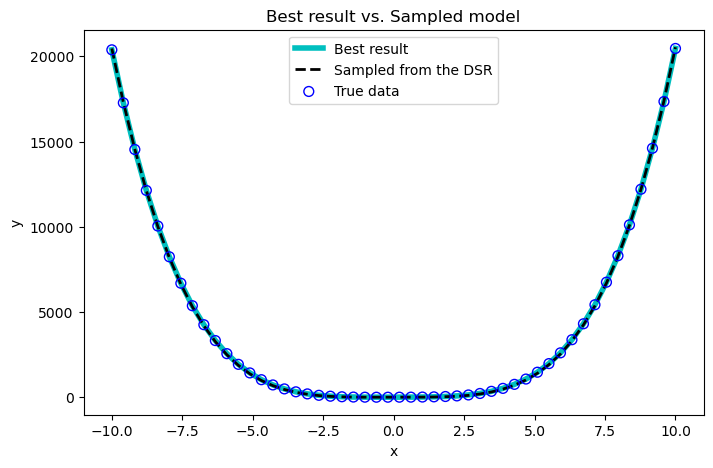

In [53]:
plt.figure(figsize = (8,5))
plt.plot(X,y_hat_best,color='c',linewidth = 4,label='Best result')
plt.plot(X,y_hat_model,'k--',linewidth=2,label='Sampled from the DSR')
plt.scatter(X,y,facecolor='none',edgecolor='b',zorder=3,s=50,label='True data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best result vs. Sampled model')
plt.legend()